# Deep-MINE Framework

## 1. Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score

import os
import time
import json
import random
import requests
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

RANDOM_SEED = 2025

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
!pip install -q ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.1 MB/s eta 0:00:00


## 2. Loading data

### 2.1 Reviews

In [ ]:
# load json
reviews = []
with open('/content/drive/MyDrive/Mestrado/Prime_Pantry.json') as f:
    for line in f:
        reviews.append(json.loads(line))

# create dataframe
df_reviews = pd.DataFrame(reviews)
print(df_reviews.shape)
df_reviews.head()

In [ ]:
df_reviews.info()

In [ ]:
# data cleaning
df_reviews = df_reviews.dropna(subset=['reviewerID', 'asin', 'reviewText'])
df_reviews = df_reviews[['reviewerID', 'asin', 'reviewText']]
print(df_reviews.shape)
df_reviews.head()

In [ ]:
print(f'Number of unique reviewers:', df_reviews['reviewerID'].nunique())

In [ ]:
print('Total number of unique products that has a review:', df_reviews['asin'].nunique())

In [ ]:
print('Total number of reviews:', df_reviews.shape[0])

In [ ]:
# check for any null value
df_reviews.isnull().sum()

### 2.2 Products

In [ ]:
# load json
products = []
with open('/content/drive/MyDrive/Mestrado/meta_Prime_Pantry.json') as f:
    for line in f:
        products.append(json.loads(line))

# create dataframe
df_products = pd.DataFrame(products)
print(df_products.shape)
df_products.head(2)

In [ ]:
# replace empty lists with null values
df_products = df_products.map(lambda x: np.nan if len(x) == 0 else x)
df_products.head(2)

In [ ]:
df_products.info()

In [ ]:
all_products = df_products['asin'].unique()
print('Total number of registred products:', df_products['asin'].shape[0])
print('Total number of unique products:', all_products.shape[0])

In [ ]:
# data cleaning
df_products_cleaned = df_products.dropna(subset=['description', 'asin', 'imageURL', 'imageURLHighRes'])
df_products_cleaned = df_products_cleaned[['description', 'asin', 'imageURL', 'imageURLHighRes']]
print(df_products_cleaned.shape)
df_products_cleaned.head(2)

In [ ]:
# check for any null value
df_products_cleaned.isnull().sum()

In [ ]:
print('Total number of registred products after cleaning:', df_products_cleaned['asin'].shape[0])
print('Total number of unique products after cleaning:', df_products_cleaned['asin'].unique().shape[0])

In [ ]:
# remove the duplicate one
df_products_cleaned = df_products_cleaned.drop_duplicates(subset=['asin'])
df_products_cleaned.shape

In [ ]:
# choose one image randomly
# df_products_cleaned['imageURL'] = df_products_cleaned['imageURL'].apply(lambda x: random.choice(x))

# choose the first image (the other images from this dataset may not be useful)
df_products_cleaned['imageURL'] = df_products_cleaned['imageURL'].apply(lambda x: x[0])

In [ ]:
# avoid urls in descriptions
df_products_cleaned['description'] = df_products_cleaned['description'].apply(lambda x: [text for text in x if 'http' not in text]).apply(lambda x: ' '.join(x))

In [ ]:
df_products_cleaned = df_products_cleaned.reset_index()

In [ ]:
df_prime_pantry = df_reviews.merge(df_products_cleaned, on='asin', how='right')  # use `right` to keep products without feedback
print(df_prime_pantry.shape)
df_prime_pantry.head()

In [ ]:
df_reviews.shape[0] - df_prime_pantry.shape[0]

#### Check inconsistencies

In [ ]:
# get products that were removed after the cleaning
removed_products = list(set(all_products) - set(df_products_cleaned['asin']))
len(removed_products)

In [ ]:
# count how many reviews has that removed products
df_reviews['asin'].isin(removed_products).sum()

Still missing 60 reviews

In [ ]:
# does reviews have products that the table of products do not have?
more_products = df_reviews[~df_reviews['asin'].isin(df_products['asin'])]['asin']
more_products.nunique()

In [ ]:
more_products.unique()

In [ ]:
more_products.shape[0]

### 2.3 Cleaning final dataset

In [ ]:
print(df_prime_pantry.shape)
df_prime_pantry.head()

In [ ]:
print(f'Number of users:', df_prime_pantry['reviewerID'].nunique())

In [ ]:
print(f'Number of products:', df_prime_pantry['asin'].nunique())

In [ ]:
sns.boxplot(df_prime_pantry['reviewerID'].value_counts())

In [ ]:
# keep only users with at least 2 feedbacks, one for training set and one for the test set
users_at_leat_two_feedbacks = df_prime_pantry['reviewerID'].value_counts()[df_prime_pantry['reviewerID'].value_counts() > 1]
df_prime_pantry = df_prime_pantry[df_prime_pantry['reviewerID'].isin(users_at_leat_two_feedbacks.index)].reset_index(drop=True).reset_index()

In [ ]:
# map null values to remove
df_prime_pantry = df_prime_pantry.replace({'None': np.nan, '': np.nan})
df_prime_pantry = df_prime_pantry.dropna()

In [ ]:
print(df_prime_pantry.shape)
df_prime_pantry.head()

In [ ]:
df_prime_pantry.isnull().sum()

In [ ]:
df_users = df_prime_pantry[['reviewerID']].drop_duplicates().reset_index(drop=True).reset_index()
df_users

#### Save datasets

In [ ]:
# feedbacks
df_prime_pantry.to_csv('prime_pantry.csv', index=False)

In [ ]:
# products
df_products_cleaned.to_csv('products.csv', index=False)

In [ ]:
# users
df_users.to_csv('users.csv', index=False)

In [ ]:
print(f'Number of users:', df_prime_pantry['reviewerID'].nunique())

In [ ]:
print(f'Number of products:', df_prime_pantry['asin'].nunique())

In [ ]:
print(f'Number of feedbacks:', df_prime_pantry.shape[0])

Matrix -> users (72,969) x products (8,468)

Feedbacks: 284,666

### 2.4 Download images

In [ ]:
def download_image_from_url(url, path):
    try:
        img_data = requests.get(url).content
        with open(path, 'wb') as handler:
            handler.write(img_data)
    except Exception as e:
        print(f'Failed to download image {url}:', e)

In [ ]:
df_prime_pantry[['asin', 'imageURL']] \
    .drop_duplicates(subset=['asin'])['imageURL'] \
    .progress_apply(lambda x: download_image_from_url(x, f'./images/{os.path.basename(x)}'))

### Check number of downloaded images

In [ ]:
all_urls = df_prime_pantry.drop_duplicates(subset=['asin'])['imageURL'].apply(os.path.basename)
all_urls

In [ ]:
import glob
all_downloaded_files = glob.glob('/content/images/*.jpg')
all_downloaded_files = list(map(os.path.basename, all_downloaded_files))
len(all_downloaded_files)

In [ ]:
all_urls.isin(all_downloaded_files).sum()

In [ ]:
all_urls.nunique()

In [ ]:
!ls -1 /content/images | wc -l

In [ ]:
# zip images
!zip -r images.zip ./images/

In [ ]:
from google.colab import files
files.download('/content/images.zip')

In [ ]:
files.download('/content/prime_pantry.csv')

In [ ]:
files.download('/content/products.csv')

In [ ]:
files.download('/content/users.csv')

### Restore dataset

In [3]:
# download dataset feedbacks
!gdown --id 1cRC7xYuMO3KvcJtqUd5d7cchPFOb2rxc

# download dataset products
!gdown --id 1Fvd2NiO858S5rFtFbOJSysWV0ITxoiAA

# download dataset users
!gdown --id 1_79FBtpDu_32P_QzpGvlO2hU1n5nRUqs

# download images
!gdown --id 1v8GyHoaeNlT11HxePCGUtiKNYVTKXRJo

!unzip images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/510smA03rCL._SS40_.jpg  
  inflating: images/417QgxMJdjL._SS40_.jpg  
  inflating: images/51dYe9MTxlL._SS40_.jpg  
 extracting: images/51Pds1nqrlL._SS40_.jpg  
  inflating: images/21BFiDdBW7L._SS40_.jpg  
  inflating: images/41Ntls1fpUL._SS40_.jpg  
  inflating: images/51cIijPUOpL._SS40_.jpg  
  inflating: images/51cnHV53LfL._SS40_.jpg  
  inflating: images/31Jof0H-00L._SS40_.jpg  
  inflating: images/41uJi7yRG1L._SS40_.jpg  
  inflating: images/51bwDxmIdQL._SS40_.jpg  
  inflating: images/4136BY-O5EL._SS40_.jpg  
  inflating: images/41xbCMsNlPL._SS40_.jpg  
  inflating: images/61jAQf6GgfL._SS40_.jpg  
  inflating: images/51djbi5SDxL._SS40_.jpg  
  inflating: images/41ozBLWD90L._SS40_.jpg  
  inflating: images/51EKzQJdtTL._SS40_.jpg  
  inflating: images/41g-MZZCWgL._SS40_.jpg  
  inflating: images/41aSb5a48zL._SS40_.jpg  
  inflating: images/41Xg79nND9L._SS40_.jpg  
  inflating: images/31mfV8l7BLL._SS40_.jpg  
  in

In [4]:
# feedbacks
df_prime_pantry = pd.read_csv('prime_pantry.csv')
print(df_prime_pantry.shape)
df_prime_pantry.head()

(284666, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
0,0,A2582KMXLK2P06,B00005BPJO,"I used to hate Milk Duds for the longest time,...",Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [5]:
# products
df_products = pd.read_csv('products.csv').reset_index()
print(df_products.shape)
df_products.head()

(8941, 5)


,index,description,asin,imageURL,imageURLHighRes
0,0,Sink your sweet tooth into MILK DUDS Candya de...,B00005BPJO,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
1,1,A perfect Lentil soup starts with Goya Lentils...,B0000DIF38,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,Saran Premium Wrap is an extra tough yet easy ...,B0000DIWNI,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Easy...,B0000DIWNZ,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,"Ibarra Chocolate, 19 Oz",B0000GH6UG,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [6]:
# users
df_users = pd.read_csv('users.csv')
print(df_users.shape)
df_users.head()

(72969, 2)


,index,reviewerID
0,0,A2582KMXLK2P06
1,1,A2K7V3G4598QRF
2,2,A4GFA67FAZ5V1
3,3,A31Y9ELLA1JUB0
4,4,A2EDR4BSO8F0E1


### Data splits

In [7]:
df_test = df_prime_pantry.sample(frac=1).drop_duplicates('reviewerID')
print(df_test.shape)
df_test.head()

(72969, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
181350,181358,A2JLB890XPZ4V0,B00VTU1HDY,"Meh, ok, seems a bit dry, doesn't drag softly ...",The pencil gives you control and versatility. ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
273979,274010,A17PTZPTGFY7H2,B01DBCCKQK,Great if you like raspberries--I like cranberr...,Nourish your strength when you start each day ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
10113,10113,AKCF6IEQLKTJE,B000RA6GMY,I love these for the price point. I'm not upse...,"Glad Food Storage Containers, Soup and Salad, ...",https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
178744,178752,A23R9K4S5VVTQR,B00VH56D26,Really great feeling,"Specially formulated for men who want clean, h...",https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
52632,52632,A24SYEQLJT7N5R,B0014CXS8O,Nothing good about this cereal,Wake up and start your day with the simple goo...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [8]:
df_train = df_prime_pantry[~df_prime_pantry['index'].isin(df_test['index'])]
print(df_train.shape)
df_train.head()

(211697, 7)


,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
1,1,A2K7V3G4598QRF,B00005BPJO,I love these. The chocolate is really good and...,Sink your sweet tooth into MILK DUDS Candya de...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,"Still infuriating to work with, and could use ...",Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,I purchased this Saran premium plastic wrap af...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,I go through a lot of plastic ware and for me ...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
5,5,A2FYW9VZ0AMXKY,B0000DIWNI,I am an avid cook and baker. Saran Premium Pl...,Saran Premium Wrap is an extra tough yet easy ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


### Bag-of-words

https://www.kaggle.com/code/ignazio/autoencoder-for-text-in-pytorch

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download("punkt")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
class Vocabulary:

    def __init__(self):
        self.stemmer = PorterStemmer()  # stemming
        self.analyzer = CountVectorizer().build_analyzer()
        self.vectorizer = CountVectorizer(analyzer=self.stemmed_words)

    # to clean data
    def replace_special_chars(self, text):
        try:
            return re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
        except:
            return None

    def normalise_text(self, text):
        text = text.str.lower()
        text = text.str.replace(r"\#","")
        text = text.str.replace(r"http\S+","URL") # \s for whitespace character and \S for non-whitespace character
        text = text.str.replace(r"@"," ")
        text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
        text = text.str.replace("\s{2,}", " ")
        text = text.apply(self.replace_special_chars)
        return text

    def preprocess(self, raw_corpus):
        corpus = self.normalise_text(raw_corpus).values.tolist()
        corpus = [x for x in corpus if not isinstance(x, float)]  # remove float nan

        # remove stop-words
        result = []
        for i in corpus:
            #out = nltk.word_tokenize(i)
            out = [x for x in i.split() if x not in stop_words]
            result.append(" ". join(out))
        return result

    def stemmed_words(self, doc):
        return (self.stemmer.stem(w) for w in self.analyzer(doc))

    def fit(self, raw_corpus):
        # preprocessing
        corpus = self.preprocess(raw_corpus)

        print('Training corpus...')
        self.vectorizer.fit(corpus)

    def transform(self, text):
        if isinstance(text, str):
            text = [text]
        x = self.vectorizer.transform(text)
        return torch.tensor(x.toarray())

    def get_vocab(self):
        vocab = self.vectorizer.get_feature_names_out()
        return vocab

    def vocab_size(self):
        return len(self.get_vocab())

In [11]:
%%time
review_vocab = Vocabulary()
review_vocab.fit(df_prime_pantry["reviewText"])
review_vocab.vocab_size()

Training corpus...
CPU times: user 1min 15s, sys: 595 ms, total: 1min 16s
Wall time: 1min 23s


29678

In [12]:
%%time
description_vocab = Vocabulary()
description_vocab.fit(df_prime_pantry["description"])
description_vocab.vocab_size()

Training corpus...
CPU times: user 8min 58s, sys: 2.98 s, total: 9min 1s
Wall time: 9min 9s


12916

In [13]:
df_train['reviewText'] = review_vocab.preprocess(df_train['reviewText'])
df_train['description'] = description_vocab.preprocess(df_train['description'])

df_test['reviewText'] = review_vocab.preprocess(df_test['reviewText'])
df_test['description'] = description_vocab.preprocess(df_test['description'])

<ipython-input-13-6bf83952d21c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['reviewText'] = review_vocab.preprocess(df_train['reviewText'])
<ipython-input-13-6bf83952d21c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['description'] = description_vocab.preprocess(df_train['description'])


In [14]:
df_train.head()

,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
1,1,A2K7V3G4598QRF,B00005BPJO,love chocolate really good love caramel unlike...,sink sweet tooth milk duds candya delicious bl...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
2,2,A4GFA67FAZ5V1,B0000DIWNI,still infuriating work could use better contai...,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
3,3,A31Y9ELLA1JUB0,B0000DIWNI,purchased saran premium plastic wrap trying re...,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
4,4,A2EDR4BSO8F0E1,B0000DIWNI,go lot plastic ware saran premium best,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
5,5,A2FYW9VZ0AMXKY,B0000DIWNI,avid cook baker saran premium plastic wrap sta...,saran premium wrap extra tough yet easy handle...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


In [15]:
df_test.head()

,index,reviewerID,asin,reviewText,description,imageURL,imageURLHighRes
181350,181358,A2JLB890XPZ4V0,B00VTU1HDY,meh ok seems bit dry drag softly across lid ki...,pencil gives control versatility want precise ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
273979,274010,A17PTZPTGFY7H2,B01DBCCKQK,great like raspberries like cranberries recomm...,nourish strength start day special k nourish c...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
10113,10113,AKCF6IEQLKTJE,B000RA6GMY,love price point upset one left work lost serv...,glad food storage containers soup salad right ...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
178744,178752,A23R9K4S5VVTQR,B00VH56D26,really great feeling,specially formulated men want clean hydrated r...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...
52632,52632,A24SYEQLJT7N5R,B0014CXS8O,nothing good cereal,wake start day simple goodness kellogg crackli...,https://images-na.ssl-images-amazon.com/images...,['https://images-na.ssl-images-amazon.com/imag...


## 3. Deep-MINE

In [16]:
# https://discuss.pytorch.org/t/how-to-share-weights-between-two-layers/55541/2
# https://www.kaggle.com/code/ignazio/autoencoder-for-text-in-pytorch


def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.xavier_uniform_(module.weight)


class ImageAutoEncoder(nn.Module):

    def __init__(self, img_size=40, n_node=100, kernel_size=3, tie_weights=True):
        super().__init__()

        # encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.fc3 = nn.Linear(25600, n_node, bias=True)

        # decoder
        self.fc4 = nn.Linear(n_node, 25600, bias=True)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=1, padding=1)
        self.conv6 = nn.Conv2d(64, 3, kernel_size=kernel_size, stride=1, padding=1)

        # utils
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.relu = nn.ReLU()  # TODO: change to sigmoid?
        # self.relu = nn.Sigmoid()

        # share encoder decoder weight matrices
        if tie_weights:
            self._tie_weights()

    def _tie_weights(self):
        self.fc4.weight.data = self.fc3.weight.data.transpose(0,1)
        self.conv5.weight.data = self.conv2.weight.data.transpose(0,1)
        self.conv6.weight.data = self.conv1.weight.data.transpose(0,1)

    def forward(self, x):
        # encoder
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.pool(h)
        h = self.fc3(h.reshape(-1, 25600))

        # decoder
        h = self.fc4(h).T
        h = h.reshape(-1, 64, 20, 20)
        h = self.upsample(h)
        h = self.relu(self.conv5(h))
        x_hat = self.relu(self.conv6(h))
        return x_hat

    def encode(self, x):
        # encoder
        h = self.relu(self.conv1(x))
        h = self.relu(self.conv2(h))
        h = self.pool(h)
        h = self.fc3(h.reshape(-1, 25600))
        return h

    def decode(self, h):
        # decoder
        h = self.fc4(h).T
        h = h.reshape(-1, 64, 20, 20)
        h = self.upsample(h)
        h = self.relu(self.conv5(h))
        x_hat = self.relu(self.conv6(h))
        return x_hat


class TextAutoEncoder(nn.Module):

    def __init__(self, vocab_size, n_node=100, hidden_size=400, tie_weights=True):
        super().__init__()

        # encoder
        self.fc1 = nn.Linear(vocab_size, hidden_size, bias=True)
        self.fc2 = nn.Linear(hidden_size, n_node, bias=True)

        # decoder
        self.fc3 = nn.Linear(n_node, hidden_size, bias=True)
        self.fc4 = nn.Linear(hidden_size, vocab_size, bias=True)

        # utils
        self.relu = nn.ReLU()  # TODO: change to sigmoid?
        # self.relu = nn.Sigmoid()

        # share encoder decoder weight matrices
        if tie_weights:
            self._tie_weights()

    def _tie_weights(self):
        self.fc3.weight.data = self.fc2.weight.data.transpose(0,1)
        self.fc4.weight.data = self.fc1.weight.data.transpose(0,1)

    def forward(self, x):
        # encoder
        h = self.relu(self.fc1(x))
        h = self.fc2(h)

        # decoder
        h = self.relu(self.fc3(h))
        x_hat = self.fc4(h)
        return x_hat

    def encode(self, x):
        # encoder
        h = self.relu(self.fc1(x))
        h = self.fc2(h)
        return h

    def decode(self, h):
        # decoder
        h = self.relu(self.fc3(h))
        x_hat = self.fc4(h)
        return x_hat

In [17]:
class DeepMINEModel(nn.Module):

    def __init__(self, n_users, n_items, img_size, review_vocab_size, desc_vocab_size):
        super().__init__()

        ### parameters ###
        self.n_users  = n_users
        self.n_items = n_items

        # preference dimensions
        self.dim_u = 20
        self.dim_theta = 20

        # autoencoders dimensions
        self.dim_node = 100

        # regularization hyparameters
        self.lambda_m = 1/40
        self.lambda_d = 1/desc_vocab_size
        self.lambda_r = 1/review_vocab_size
        self.lambda_theta = 0.1
        self.lambda_beta = 0.001
        self.lambda_Wfu = 0.001

        # lambda parameters
        self.lambda_w = 1/100
        self.lambda_b = 0
        self.lambda_q = 1/400
        self.lambda_c = 0
        self.lambda_n = 1/400
        self.lambda_t = 0

        ### weights ###
        # user perception factors
        self.u_users = nn.Embedding(self.n_users, self.dim_u)
        self.theta_users = nn.Embedding(self.n_users, self.dim_theta)

        # hidden information factor
        self.v_items = nn.Embedding(self.n_items, self.dim_u)

        # cognition factors
        self.a_1 = nn.Embedding(self.n_users, 1)
        self.a_2 = nn.Embedding(self.n_users, 1)
        self.a_3 = nn.Embedding(self.n_users, 1)

        # embedding layer of information integration
        self.embeddings = nn.Embedding(self.dim_node*3, self.dim_theta)

        # biases
        self.alpha_users = nn.Embedding(self.n_users, 1)
        self.beta_items = nn.Embedding(self.n_items, 1)

        # autoencoders
        self.images_autoencoder = ImageAutoEncoder(img_size=img_size, n_node=self.dim_node)
        self.descriptions_autoencoder = TextAutoEncoder(vocab_size=desc_vocab_size, n_node=self.dim_node)
        self.reviews_autoencoder = TextAutoEncoder(vocab_size=review_vocab_size, n_node=self.dim_node)

    def prediction(self,
                   user_id: int,
                   item_id: int,
                   m3,
                   d2,
                   r2,
                   ui_latent_factor,
                   ui_content_factor,
                   vj_hidden_info,
                   ui_bias,
                   ji_bias):
        ### user's cognitive styles ###
        ai1 = self.a_1(user_id)
        ai2 = self.a_2(user_id)
        ai3 = self.a_3(user_id)

        # softmax?
        styles = F.softmax(torch.cat([ai1, ai2, ai3], dim=1), dim=1)
        ai1, ai2, ai3 = styles[:, 0].unsqueeze(-1), styles[:, 1].unsqueeze(-1), styles[:, 2].unsqueeze(-1)

        ### information integration ###
        f_c = torch.cat([ai1.T.mm(m3), ai2.T.mm(d2), ai3.T.mm(r2)], dim=-1)
        f_j = f_c.mm(self.embeddings.weight)

        # preference
        # x_ij = ui_bias + ji_bias + ui_latent_factor.mm(vj_hidden_info.T) + ui_content_factor.mm(f_j.T)
        x_ij = ui_bias + ji_bias + (ui_latent_factor * vj_hidden_info).sum(dim=1).unsqueeze(-1) + ui_content_factor.mm(f_j.T)

        return x_ij

    def information_representation(self, image, description, review):
        # latent space
        m3 = self.images_autoencoder.encode(image)
        d2 = self.descriptions_autoencoder.encode(description)
        r2 = self.reviews_autoencoder.encode(review)

        # reconstructions
        image_hat = self.images_autoencoder.decode(m3)
        description_hat = self.descriptions_autoencoder.decode(d2)
        review_hat = self.reviews_autoencoder.decode(r2)

        return {
            'embeddings': [m3, d2, r2],
            'reconstructions': [image_hat, description_hat, review_hat]
        }

    def forward(self, user_id, p_item, p_image, p_description, p_review, n_item, n_image, n_description, n_review):
        ### information representation ###
        p_representations = self.information_representation(p_image, p_description, p_review)
        n_representations = self.information_representation(n_image, n_description, n_review)

        # latent spaces
        p_m3, p_d2, p_r2 = p_representations['embeddings']
        n_m3, n_d2, n_r2 = n_representations['embeddings']

        # reconstructions
        p_image_pred, p_description_pred, p_review_pred = p_representations['reconstructions']
        n_image_pred, n_description_pred, n_review_pred = n_representations['reconstructions']

        ### calculate user preference ###
        ui_latent_factor = self.u_users(user_id)
        ui_content_factor = self.theta_users(user_id)

        # hidden information
        p_vj_hidden_info = self.v_items(p_item)
        n_vj_hidden_info = self.v_items(n_item)

        # biases
        ui_bias = self.alpha_users(user_id)
        p_ji_bias = self.beta_items(p_item)
        n_ji_bias = self.beta_items(n_item)

        ### predictions ###
        x_ij = self.prediction(user_id, p_item, p_m3, p_d2, p_r2, ui_latent_factor, ui_content_factor, p_vj_hidden_info, ui_bias, p_ji_bias)
        x_ik = self.prediction(user_id, n_item, n_m3, n_d2, n_r2, ui_latent_factor, ui_content_factor, n_vj_hidden_info, ui_bias, n_ji_bias)

        ### losses ###
        # information representation
        l1 = torch.nn.functional.mse_loss(p_image_pred, p_image)
        l2 = torch.nn.functional.mse_loss(p_description_pred, p_description)
        l3 = torch.nn.functional.mse_loss(p_review_pred, p_review)

        # preference
        outputs = (x_ij - x_ik).squeeze()
        log_likelihood = torch.nn.functional.logsigmoid(outputs.unsqueeze(0)).sum()

        loss = -log_likelihood + l1 + l2 + l3

        return loss, outputs

    def recommend(self, user_id, item_id, image, description, review):
        ### information representation ###
        representations = self.information_representation(image, description, review)

        # latent spaces
        m3, d2, r2 = representations['embeddings']

        ### calculate user preference ###
        ui_latent_factor = self.u_users(user_id)
        ui_content_factor = self.theta_users(user_id)

        # hidden information
        vj_hidden_info = self.v_items(item_id)

        # biases
        ui_bias = self.alpha_users(user_id)
        ji_bias = self.beta_items(item_id)

        ### predictions ###
        x_ij = self.prediction(user_id, item_id, m3, d2, r2, ui_latent_factor, ui_content_factor, vj_hidden_info, ui_bias, ji_bias)

        return x_ij

In [18]:
def hit_score(item_true, items_pred):
    if item_true in items_pred:
        return 1
    return 0


def evaluate(model, dataloader):
    HR = []
    AUC = []
    size = 100
    model.eval()
    for idx, data in enumerate(pbar := tqdm(dataloader, total=size)):
        # user_id, positive_item, negative_item = data
        user_id = data['user_ids']
        positive_item = data['pos_item']
        negative_item = data['neg_item']

        p_item, p_image, p_description, p_review = positive_item['ids'], positive_item['images'], positive_item['descriptions'], positive_item['reviews']
        n_item, n_image, n_description, n_review = negative_item['ids'], negative_item['images'], negative_item['descriptions'], negative_item['reviews']

        with torch.no_grad():
            pred_p = model.recommend(user_id.to(device), p_item.to(device), p_image.to(device), p_description.to(device), p_review.to(device))
            pred_n = model.recommend(user_id.repeat(n_item.shape[0]).to(device), n_item.to(device), n_image.to(device), n_description.to(device), n_review.to(device))

        predictions = torch.cat([pred_p, pred_n], dim=0).squeeze().cpu()

        # hit-ratio
        _, indices = torch.topk(predictions, k=1)
        recommends = torch.take(torch.cat([p_item, n_item], dim=0).squeeze(), indices)
        hit = hit_score(p_item, recommends)

        # roc-auc
        roc_auc = roc_auc_score(np.array([1] + [0]*(predictions.shape[0]-1)), predictions.numpy())

        HR.append(hit)
        AUC.append(roc_auc)

        pbar.set_postfix(hit=np.mean(HR), roc_auc=np.mean(AUC))
        pbar.update()

        if idx >= size:
            break
    print('Hit-Ratio:', np.mean(HR))
    print('ROC-AUC:', np.mean(AUC))

In [19]:
class Encoder():

    def __init__(self, df_feedbacks, df_products, df_users):
        self.df_feedbacks = df_feedbacks
        self.df_products = df_products
        self.df_users = df_users

    def process(self, batch):
        u_ls = []
        pos_ids = []
        pos_imgs = []
        pos_descs = []
        pos_revs = []
        neg_ids = []
        neg_imgs = []
        neg_descs = []
        neg_revs = []
        for data in batch:
            u = data[0]
            i = data[1]
            j = data[2]

            user_key = self.df_users[self.df_users['index'] == u]['reviewerID'].iloc[0]
            pos_feedback = self.df_feedbacks[self.df_feedbacks['reviewerID'] == user_key].iloc[0]

            image_name = os.path.basename(pos_feedback['imageURL'])
            p_image = load_image(os.path.join('./images/', image_name))
            p_description = description_vocab.transform(pos_feedback['description']).squeeze(0).float()
            p_review = review_vocab.transform(pos_feedback['reviewText']).squeeze(0).float()

            imgs = []
            descs = []
            revs = []
            for neg_item_id in j:
                item_key = self.df_products[self.df_products['index'] == neg_item_id]['asin'].iloc[0]

                try:
                    neg_feedback = self.df_feedbacks[self.df_feedbacks['asin'] == item_key].sample(1).iloc[0]

                    image_name = os.path.basename(neg_feedback['imageURL'])
                    n_image = load_image(os.path.join('./images/', image_name))
                    n_description = description_vocab.transform(neg_feedback['description']).squeeze(0).float()
                    n_review = review_vocab.transform(neg_feedback['reviewText']).squeeze(0).float()
                except:
                    n_image = torch.zeros(3, 40, 40)
                    n_description = torch.zeros((12916,))
                    n_review = torch.zeros((29678,))

                imgs.append(n_image.unsqueeze(0))
                descs.append(n_description.unsqueeze(0))
                revs.append(n_review.unsqueeze(0))

            u_ls.append(torch.tensor(u).unsqueeze(0))
            pos_ids.append(torch.tensor(i).unsqueeze(0))
            pos_imgs.append(p_image.unsqueeze(0))
            pos_descs.append(p_description.unsqueeze(0))
            pos_revs.append(p_review.unsqueeze(0))
            neg_ids.append(torch.tensor(j))
            neg_imgs.append(torch.cat(imgs))
            neg_descs.append(torch.cat(descs))
            neg_revs.append(torch.cat(revs))

        return {
            'user_ids': torch.cat(u_ls),
            'pos_item': {
                'ids': torch.cat(pos_ids),
                'images': torch.cat(pos_imgs),
                'descriptions': torch.cat(pos_descs),
                'reviews': torch.cat(pos_revs)
            },
            'neg_item': {
                'ids': torch.cat(neg_ids, dim=0),
                'images': torch.cat(neg_imgs),
                'descriptions': torch.cat(neg_descs),
                'reviews': torch.cat(neg_revs)
            }
        }

In [20]:
def load_image(path, resize=(40, 40)):
    numpy_img = np.array(Image.open(path).resize(resize))
    if numpy_img.ndim == 2:
        numpy_img = np.repeat(numpy_img[:, :, np.newaxis], 3, axis=2)
    return torch.from_numpy(numpy_img).view(3, 40, 40) / 255


class DeepMINEDataset(Dataset):

    def __init__(self, df_feedbacks, df_products, df_users, n_neg_items=1):
        self.df_feedbacks = df_feedbacks
        self.df_products = df_products
        self.df_users = df_users
        self.n_neg_items = n_neg_items

    def __len__(self):
        return self.df_feedbacks.shape[0]

    def __getitem__(self, idx):
        pos_feedback = self.df_feedbacks.iloc[idx]
        u = self.df_users[self.df_users['reviewerID'] == pos_feedback['reviewerID']]['index'].iloc[0]
        i = self.df_products[self.df_products['asin'] == pos_feedback['asin']]['index'].iloc[0]

        user_key = pos_feedback['reviewerID']
        user_products = list(self.df_feedbacks.query("reviewerID == @user_key")['asin'].unique())  # list all products user has a feedback
        found_neg_item = False
        # while found_neg_item is False:
        n_item_key = self.df_products.query("asin != @user_products").sample(self.n_neg_items)['asin'].to_list()  # get a random negative product
        all_neg_feedbacks = self.df_feedbacks[self.df_feedbacks['asin'].isin(n_item_key)]
            # if all_neg_feedbacks.shape[0] > 0 and all_neg_feedbacks['asin'].nunique() == self.n_neg_items:
            #     found_neg_item = True
        j = self.df_products[self.df_products['asin'].isin(n_item_key)]['index'].to_list()

        return u, i, j

In [21]:
n_users = df_prime_pantry['reviewerID'].nunique()
n_items = df_products['asin'].nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)
print('Number of items that has not feedback:', df_products.shape[0] - df_products['asin'].isin(df_prime_pantry['asin']).sum())

Number of users: 72969
Number of items: 8941
Number of items that has not feedback: 473


In [22]:
model = DeepMINEModel(
    n_users=n_users,
    n_items=n_items,
    img_size=40,
    review_vocab_size=review_vocab.vocab_size(),
    desc_vocab_size=description_vocab.vocab_size(),
).to(device)
model.apply(init_weights)
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
model

Number of parameters: 42907070


DeepMINEModel(
  (u_users): Embedding(72969, 20)
  (theta_users): Embedding(72969, 20)
  (v_items): Embedding(8941, 20)
  (a_1): Embedding(72969, 1)
  (a_2): Embedding(72969, 1)
  (a_3): Embedding(72969, 1)
  (embeddings): Embedding(300, 20)
  (alpha_users): Embedding(72969, 1)
  (beta_items): Embedding(8941, 1)
  (images_autoencoder): ImageAutoEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc3): Linear(in_features=25600, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=25600, bias=True)
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (upsample): Upsample(scale_factor=2.0, mode='bilinear')
    (relu): ReLU()
  )
  (descriptions_autoencoder)

In [23]:
test_encoder = Encoder(df_test, df_products, df_users)
test_data = DeepMINEDataset(df_test, df_products, df_users, n_neg_items=10)
test_dataloader = DataLoader(test_data, batch_size=1, collate_fn=test_encoder.process, shuffle=False, num_workers=0)
evaluate(model, test_dataloader)

100%|██████████| 100/100 [00:34<00:00,  2.88it/s, hit=0.0594, roc_auc=0.411]

Hit-Ratio: 0.0594059405940594
ROC-AUC: 0.4108910891089108


In [24]:
train_encoder = Encoder(df_train, df_products, df_users)
training_data = DeepMINEDataset(df_train, df_products, df_users, n_neg_items=1)
train_dataloader = DataLoader(training_data, batch_size=16, collate_fn=train_encoder.process, shuffle=True, num_workers=0)

optim_params = [
    # images
    {
        "params": [model.images_autoencoder.conv1.weight, model.images_autoencoder.conv2.weight, model.images_autoencoder.fc3.weight],
        "weight_decay": model.lambda_w,
    },
    {
        "params": [model.images_autoencoder.conv1.bias, model.images_autoencoder.conv2.bias, model.images_autoencoder.fc3.bias],
        "weight_decay": model.lambda_b,
    },
    # descriptions
    {
        "params": [model.descriptions_autoencoder.fc1.weight, model.descriptions_autoencoder.fc2.weight],
        "weight_decay": model.lambda_q,
    },
    {
        "params": [model.descriptions_autoencoder.fc1.bias, model.descriptions_autoencoder.fc2.bias],
        "weight_decay": model.lambda_c,
    },
    # reviews
    {
        "params": [model.reviews_autoencoder.fc1.weight, model.reviews_autoencoder.fc2.weight],
        "weight_decay": model.lambda_n,
    },
    {
        "params": [model.reviews_autoencoder.fc1.bias, model.reviews_autoencoder.fc2.bias],
        "weight_decay": model.lambda_t,
    },
    # user perception factors
    {
        "params": [model.u_users.weight, model.theta_users.weight],
        "weight_decay": model.lambda_theta,
    },
    # hidden information factor
    {
        "params": [model.v_items.weight],
        "weight_decay": model.lambda_theta,
    },
    # biases
    {
        "params": [model.alpha_users.weight, model.beta_items.weight],
        "weight_decay": model.lambda_beta,
    },
    # embedding layer of information integration
    {
        "params": [model.embeddings.weight],
        "weight_decay": model.lambda_Wfu,
    },
    # cognition factors
    {
        "params": [model.a_1.weight, model.a_2.weight, model.a_3.weight],
        "weight_decay": model.lambda_Wfu,
    },
]
optimizer = torch.optim.SGD(optim_params, lr=1e-3, momentum=0.9)

loss_history = []
for epoch in range(1):
    model.train()
    running_loss = 0.0
    for idx, data in enumerate(pbar := tqdm(train_dataloader)):
        optimizer.zero_grad()
        user_id = data['user_ids']
        positive_item = data['pos_item']
        negative_item = data['neg_item']

        p_item, p_image, p_description, p_review = positive_item['ids'], positive_item['images'], positive_item['descriptions'], positive_item['reviews']
        n_item, n_image, n_description, n_review = negative_item['ids'], negative_item['images'], negative_item['descriptions'], negative_item['reviews']

        loss, outputs = model(
            user_id.to(device),
            p_item.to(device),
            p_image.to(device),
            p_description.to(device),
            p_review.to(device),
            n_item.to(device),
            n_image.to(device),
            n_description.to(device),
            n_review.to(device)
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss/(idx+1))
        pbar.update()

        loss_history.append(loss.item())

 21%|██        | 2714/13232 [1:55:25<7:27:20,  2.55s/it, loss=8.25]


KeyboardInterrupt: 

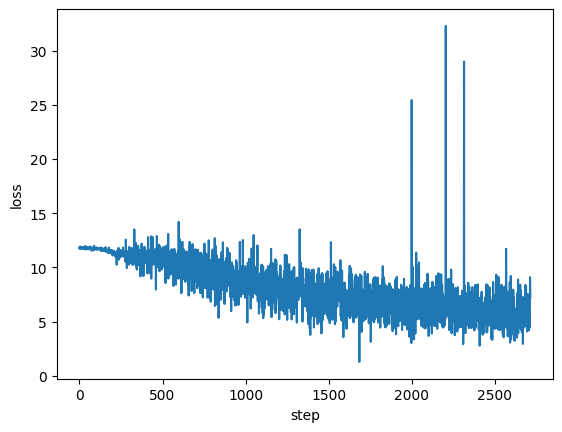

In [25]:
sns.lineplot(loss_history)
plt.xlabel('step')
plt.ylabel('loss')
plt.show()

In [26]:
evaluate(model, test_dataloader)

100%|██████████| 100/100 [00:37<00:00,  2.68it/s, hit=0.743, roc_auc=0.841]

Hit-Ratio: 0.7425742574257426
ROC-AUC: 0.8405940594059408


Perhaps check these references:

- https://github.com/sh0416/bpr/blob/master/train.py
- https://github.com/recommenders-team/recommenders/blob/main/examples/02_model_collaborative_filtering/cornac_bpr_deep_dive.ipynb
- https://medium.com/data-science/recommender-system-bayesian-personalized-ranking-from-implicit-feedback-78684bfcddf6
- https://github.com/PreferredAI/cornac/blob/93058c04a15348de60b5190bda90a82dafa9d8b6/cornac/models/vbpr/recom_vbpr.py#L249
- https://github.com/guoyang9/BPR-pytorch/tree/master
- https://ethen8181.github.io/machine-learning/recsys/4_bpr.html

**BPR: Bayesian Personalized Ranking**

![](https://seunghan96.github.io/assets/img/recsys/24-4.png)

**VBPR: Visual Bayesian Personalized Ranking**

- Paper: https://arxiv.org/pdf/1510.01784
- Github: https://github.com/aaossa/VBPR-PyTorch
- Github: https://github.com/arogers1/VBPR

![](https://raw.githubusercontent.com/aaossa/VBPR-PyTorch/main/vbpr.png?raw=True)

![](https://velog.velcdn.com/images/hyxxnii/post/732ba898-f3bb-4814-870e-0e49b7e13194/image.png)